# Projet 7 : Réalisez des indexations automatiques d’images
# <u>A. Analyse et préparation des données</u> <br/>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show
import seaborn as sns

import os
import shutil
import random

from scipy import io
import scipy.ndimage as spi
from glob import glob

import time

import cv2

from PIL import Image, ImageOps, ImageFilter
from matplotlib.pyplot import imshow

%matplotlib inline

In [3]:
DATA_DIR = 'data'
LIST_DIR = DATA_DIR + '/lists'
IMAGE_DIR = DATA_DIR + '/Images'
TRAIN_DIR = DATA_DIR + '/train'
TEST_DIR = DATA_DIR + '/test'
ANNOTATION_DIR = DATA_DIR + '/Annotation'

# 1. Analyse exploratoire

Voyons la volumétrie de nos données

In [3]:
image_files = glob(IMAGE_DIR + '/*/*.jpg')
folders = [ name for name in os.listdir(IMAGE_DIR) if os.path.isdir(os.path.join(IMAGE_DIR, name)) ]

In [4]:
print("Total races (dossier) : ", len(folders))
print("Total images  : ",len(image_files))

Total races (dossier) :  120
Total images  :  20581


Avons nous des images de même taille ?

In [5]:
img_size = np.asarray([plt.imread(f).shape for f in image_files])

Text(0,0.5,'hauteur')

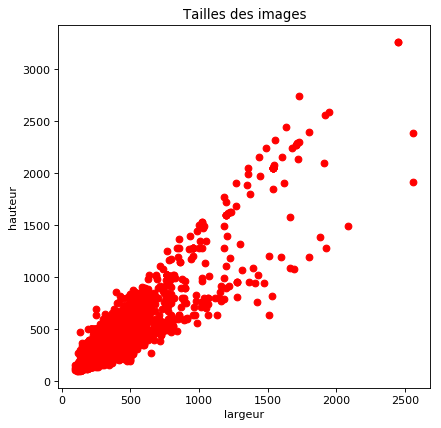

In [6]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(img_size[:,0], img_size[:,1], c = 'red')
plt.title("Tailles des images")
plt.xlabel("largeur")
plt.ylabel("hauteur")

Nombre d'images par race.

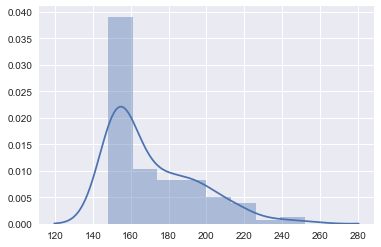

In [7]:
sns.set(color_codes=True)
images_per_feed = np.array([len(glob(IMAGE_DIR + "/" + f + '/*.jpg')) for f in folders])
sns.distplot(images_per_feed)

- Chaque dossier contient au minimum 150 images. 
- La grande majorité des dossiers ont 150 images.
- Le maximum d'images est de 280

# 2. Annotations

Lecture des fichiers annotations

In [4]:
from xml.dom import minidom
rows_list = []
for root, subdirs, files in os.walk(ANNOTATION_DIR):
    for filename in files:
        if (filename.startswith('n')) :
            file_path = os.path.join(root, filename)
            with open(file_path, 'rb') as f:
                annon_xml = minidom.parse(f)
                dog_info={}
                a_folder = annon_xml.getElementsByTagName('folder')[0].firstChild.nodeValue
                a_filename = annon_xml.getElementsByTagName('filename')[0].firstChild.nodeValue
                if (a_folder == '%s') :
                    a_folder = filename.split('_')[0][1:]
                dog_info['folder'] = a_folder
                if (a_filename == '%s') :
                    a_filename = filename   
                dog_info['filename'] = a_filename
                dog_info['breed'] = annon_xml.getElementsByTagName('name')[0].firstChild.nodeValue
                dog_info['xmin'] = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
                dog_info['ymin'] = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
                dog_info['xmax'] = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
                dog_info['ymax'] = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
                rows_list.append(dog_info)
annotations_df=pd.DataFrame(rows_list)
annotations_df = annotations_df[['folder', 'filename', 'breed', 'xmin', 'ymin', 'xmax', 'ymax']]

In [9]:
annotations_df.head()

,folder,filename,breed,xmin,ymin,xmax,ymax
0,02097658,n02097658_98,silky_terrier,93,117,269,289
1,02097658,n02097658_2535,silky_terrier,216,69,498,289
2,02097658,n02097658_271,silky_terrier,0,0,366,331
3,02097658,n02097658_427,silky_terrier,174,1,1018,762
4,02097658,n02097658_4890,silky_terrier,124,27,357,281


# 3.  Manipulation des images

In [10]:
def show_images(img1, cmap1, img2, cmap2) :
    f = plt.figure(figsize=(10,10))
    i1 = f.add_subplot(1,2, 1)
    i1.axis('off')
    imshow(img1, cmap = cmap1)
    i2 = f.add_subplot(1,2, 2)
    i2.axis('off')
    imshow(img2, cmap=cmap2)
    plt.show(block=True)

Largeur : 427 px, hauteur : 392 px channels: 3


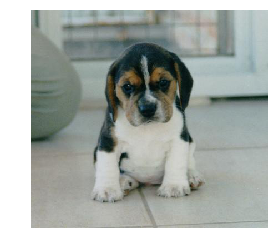

In [11]:
img_orig = cv2.imread(IMAGE_DIR + '/n02088364-beagle/n02088364_1507.jpg')
# Récupérer et afficher la taille de l'image (en pixels)
h, w, channel = img_orig.shape
print("Largeur : {} px, hauteur : {} px channels: {}".format(w, h, channel))
plt.axis('off')
imshow(cv2.cvtColor(img_orig, cv2.CV_32S))

### Gray Scale

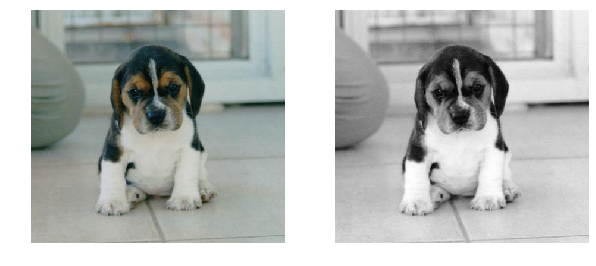

In [12]:
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, gray, 'gray')

### Equalize Histogram

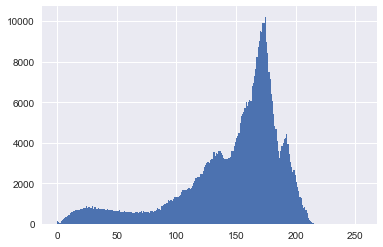

In [13]:
n, bins, patches = plt.hist(np.array(img_orig).flatten(), bins=range(256))
plt.show()

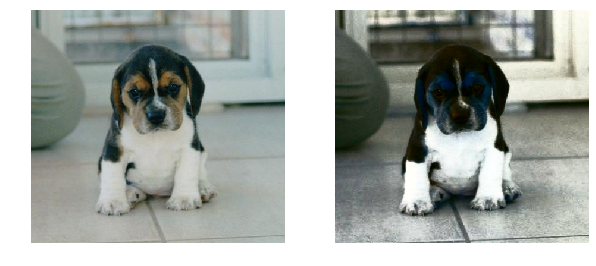

In [14]:
img_yuv = cv2.cvtColor(img_orig, cv2.COLOR_BGR2YUV)
# equalize the histogram of the Y channel
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

# convert the YUV image back to RGB format
img_trans = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, img_trans, None)

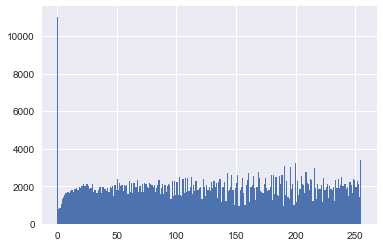

In [15]:
n, bins, patches = plt.hist(np.array(img_trans).flatten(), bins=range(256))
plt.show()

### Cropping

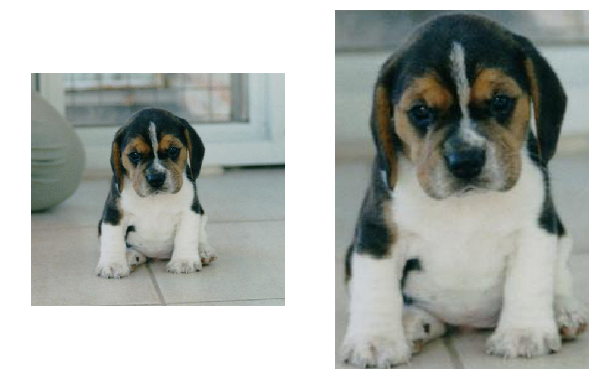

In [16]:
box = annotations_df[annotations_df['filename'] == 'n02088364_1507']
cropped_img = img_orig[int(box.ymin):int(box.ymax), int(box.xmin):int(box.xmax)]
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, cv2.cvtColor(cropped_img, cv2.CV_32S), None)

### Gaussian Blur

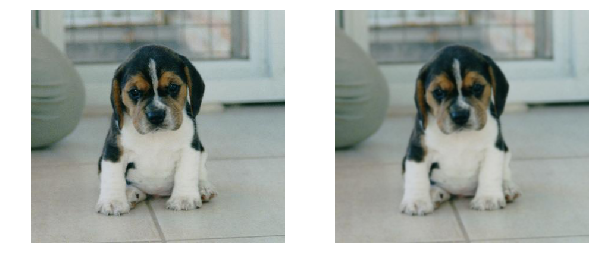

In [17]:
blur = cv2.GaussianBlur(img_orig,(5,5),0)
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, cv2.cvtColor(blur, cv2.CV_32S), None)

### Removing background

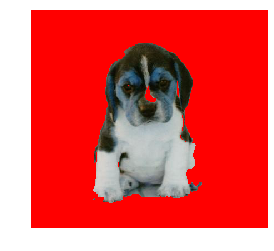

In [18]:
mask = np.zeros(img_orig.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
nb_iter = 2

#rect = (1,1,img_orig.shape[1]-1,img_orig.shape[0]-1)
rect = (10,10,400,400)

cv2.grabCut(img_orig,mask,rect,bgdModel,fgdModel,nb_iter,cv2.GC_INIT_WITH_RECT)

fgd_mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img_grabcut = img_orig*fgd_mask[:,:,np.newaxis]

bgd_mask = np.where((mask==2)|(mask==0),1,0).astype('uint8')
# Transform to red color
bkgd_red = np.full(img_orig.shape, (255,0,0), dtype=np.uint8) * bgd_mask[:,:,np.newaxis]

# Add the red background to the image
img_grabcut = img_grabcut + bkgd_red
plt.axis('off')
plt.imshow(img_grabcut)

# 4. SIFT features

In [19]:
def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    plt.axis('off')
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

def feature_extract(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    # desc is the SIFT descriptors
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    plt.axis('off')
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

In [20]:
image_path = IMAGE_DIR + '/n02085936-Maltese_dog/n02085936_544.jpg'

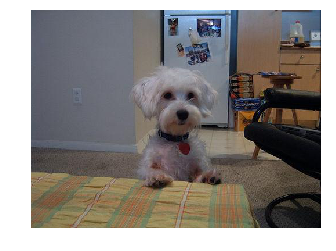

In [21]:
image = cv2.imread(image_path)
show_rgb_img(image)
image_gray = to_gray(image)

In [22]:
kp, desc = feature_extract(image_gray)

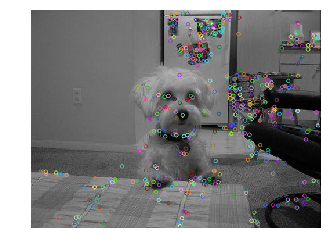

In [23]:
show_sift_features(image_gray, image, kp)

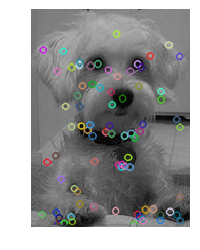

In [24]:
box = annotations_df[annotations_df['filename'] == 'n02085936_544']
cropped_img = image[int(box.ymin):int(box.ymax), int(box.xmin):int(box.xmax)]
img_gray = to_gray(cropped_img)
kp, desc = feature_extract(img_gray)
show_sift_features(img_gray, cropped_img, kp)

# 5. Préparation des données entrainement et test

In [5]:
breeds_to_use = ['Siberian_husky', 'Chihuahua', 'Maltese_dog', 'Scotch_terrier', 'Irish_setter']

On récupère le nom des dossiers qui se trouvent dans image et qui contiennent notre selection de races.

In [6]:
image_paths = glob(IMAGE_DIR + '/*')
project_image_folders = [s[12:] for s in image_paths if s.split('-')[1] in breeds_to_use]

In [7]:
project_image_folders

['n02110185-Siberian_husky',
 'n02085936-Maltese_dog',
 'n02085620-Chihuahua',
 'n02097298-Scotch_terrier',
 'n02100877-Irish_setter']

#### Image cropping

In [8]:
def retrieveBoxingArea(filename) :
    box = annotations_df[annotations_df['filename'] == filename]
    area = (int(box.xmin), int(box.ymin), int(box.xmax), int(box.ymax))
    return area

In [9]:
def saveCroppedImages(image_folder) :
    image_list = glob(image_folder + '/*/*.jpg')
    for file in image_list:   
        # Load image
        img = Image.open(file)
        # cropping
        filename = file.split("/")[-1][:-4]
        img = img.crop(retrieveBoxingArea(filename))
        img.save(file)

#### Image labels

In [10]:
def save_labels(image_folder) :
    rows_list = []
    image_list = glob(image_folder + '/*/*.jpg')
    for file in image_list:
        file_info={}
        file_info['folder'] = file.split("/")[-2]
        file_info['breed'] = file_info['folder'].split("-")[1]
        file_info['id'] = file.split("/")[-1][:-4]
        rows_list.append(file_info)
    labels=pd.DataFrame(rows_list)
    labels = labels[['id', 'breed', 'folder']]
    labels.to_csv(image_folder + '/labels.csv')

On se base sur le fichier train_list et test_list pour configurer nos jeux d'entrainement et de test.

In [11]:
def copy_image_files(breed_folder, filter_list, dest_folder, n):
    files = [file for file in filter_list if breed_folder in file]
    random.shuffle(files)
    if len(files) > n:
        files = files[:n]
    for file in files:
        shutil.copyfile(os.path.join(IMAGE_DIR, file), os.path.join(dest_folder, file))

In [13]:
num_images = 30

train_list = io.loadmat(LIST_DIR +'/train_list.mat')['file_list']
train_list = np.array([t[0] for t in train_list[:,0] if t[0].split('/')[0] in project_image_folders ])

test_list = io.loadmat(LIST_DIR +'/test_list.mat')['file_list']
test_list = np.array([t[0] for t in test_list[:,0] if t[0].split('/')[0] in project_image_folders ])

for folder in project_image_folders:
    os.makedirs(TRAIN_DIR + '/' + folder)
    os.makedirs(TEST_DIR + '/' + folder)
    copy_image_files(folder, train_list, TRAIN_DIR, int(num_images * 0.8))
    copy_image_files(folder, test_list, TEST_DIR, int(num_images * 0.2))

saveCroppedImages(TRAIN_DIR)
saveCroppedImages(TEST_DIR)
save_labels(TRAIN_DIR)
save_labels(TEST_DIR)